In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics

# Data Preprocessing

In [2]:
train = pd.read_csv("train.csv")
val = pd.read_csv("validation.csv")
test = pd.read_csv("test.csv")

#Eliminamos la primera columna, generada al pasar el conjunto de datos a formato csv.
train=train.drop(columns='Unnamed: 0')
val=val.drop(columns='Unnamed: 0')
test=test.drop(columns='Unnamed: 0')

train['proto'] = train['proto'].map({'TCP': 0, 'UDP': 1})
val['proto'] = val['proto'].map({'TCP': 0, 'UDP': 1})
test['proto'] = test['proto'].map({'TCP': 0, 'UDP': 1})

In [3]:
# Grouping the variable push flag into 10 bins
bins = [-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
labels = [i for i in range(len(bins)-1)]

train['ip.flags.df'] = pd.cut(train['ip.flags.df'], bins=bins, labels=labels, right=True, include_lowest=True)
val['ip.flags.df'] = pd.cut(val['ip.flags.df'], bins=bins, labels=labels, right=True, include_lowest=True)
test['ip.flags.df'] = pd.cut(test['ip.flags.df'], bins=bins, labels=labels, right=True, include_lowest=True)

train['tcp.flags.res'] = pd.cut(train['tcp.flags.res'], bins=bins, labels=labels, right=True, include_lowest=True)
val['tcp.flags.res'] = pd.cut(val['tcp.flags.res'], bins=bins, labels=labels, right=True, include_lowest=True)
test['tcp.flags.res'] = pd.cut(test['tcp.flags.res'], bins=bins, labels=labels, right=True, include_lowest=True)

train['tcp.flags.cwr'] = pd.cut(train['tcp.flags.cwr'], bins=bins, labels=labels, right=True, include_lowest=True)
val['tcp.flags.cwr'] = pd.cut(val['tcp.flags.cwr'], bins=bins, labels=labels, right=True, include_lowest=True)
test['tcp.flags.cwr'] = pd.cut(test['tcp.flags.cwr'], bins=bins, labels=labels, right=True, include_lowest=True)

train['tcp.flags.ecn'] = pd.cut(train['tcp.flags.ecn'], bins=bins, labels=labels, right=True, include_lowest=True)
val['tcp.flags.ecn'] = pd.cut(val['tcp.flags.ecn'], bins=bins, labels=labels, right=True, include_lowest=True)
test['tcp.flags.ecn'] = pd.cut(test['tcp.flags.ecn'], bins=bins, labels=labels, right=True, include_lowest=True)

train['tcp.flags.urg'] = pd.cut(train['tcp.flags.urg'], bins=bins, labels=labels, right=True, include_lowest=True)
val['tcp.flags.urg'] = pd.cut(val['tcp.flags.urg'], bins=bins, labels=labels, right=True, include_lowest=True)
test['tcp.flags.urg'] = pd.cut(test['tcp.flags.urg'], bins=bins, labels=labels, right=True, include_lowest=True)

train['tcp.flags.ack'] = pd.cut(train['tcp.flags.ack'], bins=bins, labels=labels, right=True, include_lowest=True)
val['tcp.flags.ack'] = pd.cut(val['tcp.flags.ack'], bins=bins, labels=labels, right=True, include_lowest=True)
test['tcp.flags.ack'] = pd.cut(test['tcp.flags.ack'], bins=bins, labels=labels, right=True, include_lowest=True)

train['tcp.flags.reset'] = pd.cut(train['tcp.flags.reset'], bins=bins, labels=labels, right=True, include_lowest=True)
val['tcp.flags.reset'] = pd.cut(val['tcp.flags.reset'], bins=bins, labels=labels, right=True, include_lowest=True)
test['tcp.flags.reset'] = pd.cut(test['tcp.flags.reset'], bins=bins, labels=labels, right=True, include_lowest=True)

train['tcp.flags.syn'] = pd.cut(train['tcp.flags.syn'], bins=bins, labels=labels, right=True, include_lowest=True)
val['tcp.flags.syn'] = pd.cut(val['tcp.flags.syn'], bins=bins, labels=labels, right=True, include_lowest=True)
test['tcp.flags.syn'] = pd.cut(test['tcp.flags.syn'], bins=bins, labels=labels, right=True, include_lowest=True)

train['tcp.flags.push'] = pd.cut(train['tcp.flags.push'], bins=bins, labels=labels, right=True, include_lowest=True)
val['tcp.flags.push'] = pd.cut(val['tcp.flags.push'], bins=bins, labels=labels, right=True, include_lowest=True)
test['tcp.flags.push'] = pd.cut(test['tcp.flags.push'], bins=bins, labels=labels, right=True, include_lowest=True)

train['tcp.flags.fin'] = pd.cut(train['tcp.flags.fin'], bins=bins, labels=labels, right=True, include_lowest=True)
val['tcp.flags.fin'] = pd.cut(val['tcp.flags.fin'], bins=bins, labels=labels, right=True, include_lowest=True)
test['tcp.flags.fin'] = pd.cut(test['tcp.flags.fin'], bins=bins, labels=labels, right=True, include_lowest=True)

In [4]:
train.groupby(['category', 'tcp.flags.syn']).size().reset_index(name='count')

/tmp/ipykernel_2458741/3673978437.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train.groupby(['category', 'tcp.flags.syn']).size().reset_index(name='count')


,category,tcp.flags.syn,count
0,Benign,0,81331
1,Benign,1,9062
2,Benign,2,17639
3,Benign,3,202
4,Benign,4,78
...,...,...,...
105,Recon-PortScan,6,2
106,Recon-PortScan,7,140
107,Recon-PortScan,8,10
108,Recon-PortScan,9,9


In [4]:
porcentaje_mantener = 0.001

train_reducido_udp = train[train['proto'] == 1].groupby('category').sample(frac=porcentaje_mantener)
train_reducido_tcp = train[train['proto'] == 0].groupby('category').sample(frac=porcentaje_mantener)

train = pd.concat([train_reducido_udp, train_reducido_tcp])


test_reducido_udp = test[test['proto'] == 1].groupby('category').sample(frac=porcentaje_mantener)
test_reducido_tcp = test[test['proto'] == 0].groupby('category').sample(frac=porcentaje_mantener)

test = pd.concat([test_reducido_udp, test_reducido_tcp])

In [4]:
# Separar características y etiquetas para conjunto de entrenamiento
X_train = train.drop(columns=['category'])
y_train = train['category']

# Separar características y etiquetas para conjunto de entrenamiento
X_test = test.drop(columns=['category'])
y_test = test['category']

X_val = val.drop(columns=['category'])
y_val = val['category']

## Full-Feature Model Evaluation

In [6]:
X_train.shape, X_test.shape

((1117830, 56), (319400, 56))

In [7]:
RF = RandomForestClassifier()

param_grid = {'max_depth': [15]} 
grid = GridSearchCV(RF, param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose=1)
grid.fit(X_train, y_train)

print('Best Cross Validation Score:', grid.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Cross Validation Score: 0.8331087911399766


In [8]:
RF =  grid.best_estimator_

print('Train Score:', RF.score(X_train, y_train))

y_pred = RF.predict(X_test)

start2=time.time()
print('Precision en test: ', accuracy_score(y_test, y_pred))
stop2=time.time()

tiempo2 = stop2 - start2
print(f"Tiempo de prediccion (Test) RF: {tiempo2}s")

Train Score: 0.8654652317436462
Precision en test:  0.8587852222917971
Tiempo de prediccion (Test) RF: 0.2657492160797119s


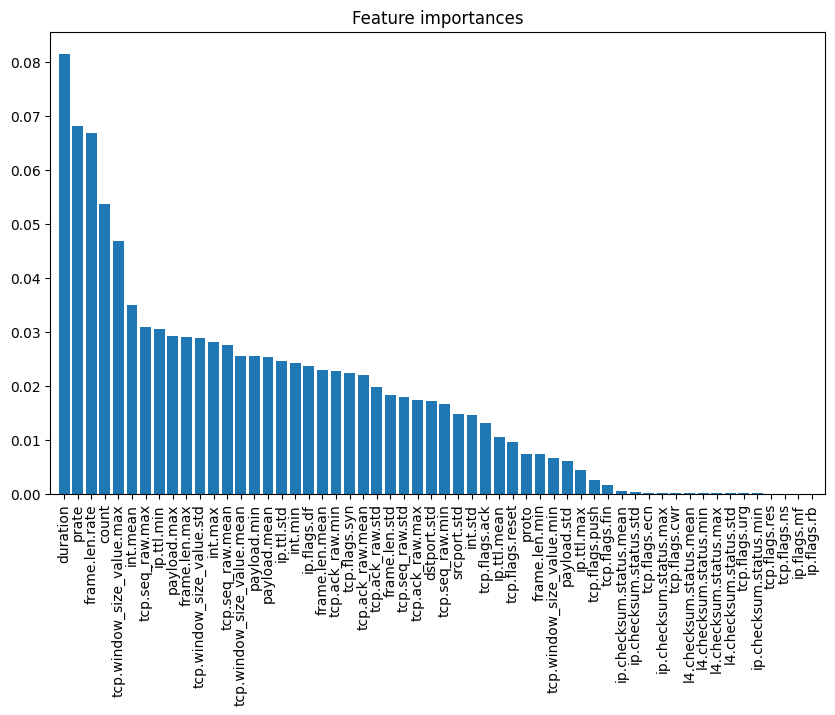

In [10]:
importances = RF.feature_importances_
#plotamos la importancia de las variables
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

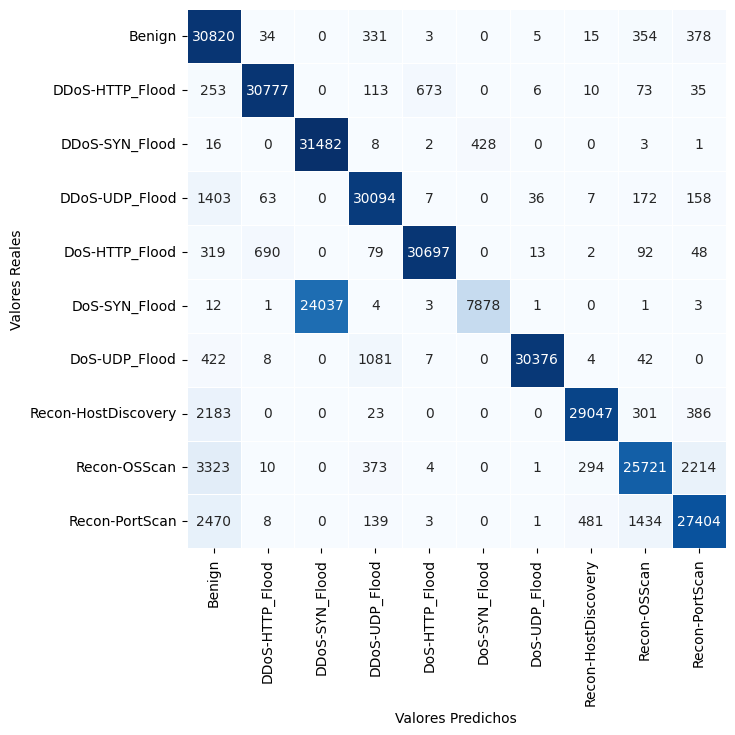

In [11]:
cm = metrics.confusion_matrix(y_test, y_pred)
normalized_matrix = cm #/ cm.sum(axis=1, keepdims=True)

class_names = ['Benign', 'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DDoS-UDP_Flood', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-UDP_Flood', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan']

sns.heatmap(normalized_matrix, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names,
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(7, 7)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

# Dropping Constant and Quasi-constant features

## First method

We consider the feature as a quasi-constant feature, if the predominant value has more than X % of the observations

In [5]:
quasi_constant_feat = []

for feature in X_train.columns:
    
    predominant = X_train[feature].value_counts(normalize=True).values[0]
    
    # 
    if predominant > 0.998:
        quasi_constant_feat.append(feature)
        
len(quasi_constant_feat)
    

12

In [6]:
quasi_constant_feat

['ip.flags.rb',
 'ip.flags.mf',
 'tcp.flags.res',
 'tcp.flags.ns',
 'tcp.flags.cwr',
 'tcp.flags.ecn',
 'tcp.flags.urg',
 'ip.checksum.status.min',
 'l4.checksum.status.std',
 'l4.checksum.status.min',
 'l4.checksum.status.max',
 'l4.checksum.status.mean']

In [7]:
X_train.drop(labels=quasi_constant_feat, axis=1, inplace=True)
X_val.drop(labels=quasi_constant_feat, axis=1, inplace=True)
X_test.drop(labels=quasi_constant_feat, axis=1, inplace=True)

X_train.shape, X_test.shape, X_val.shape

((1117830, 44), (319400, 44), (159690, 44))

## Second Method

We consider the feature as a quasi-constant feature if the variance of the feature is over 0.01

In [8]:
sel = VarianceThreshold(threshold=0.01)
sel.fit(X_train)

VarianceThreshold(threshold=0.01)

In [9]:
quasi_constant = X_train.columns[~sel.get_support()]

len(quasi_constant)

3

In [10]:
features = X_train.columns[sel.get_support()]

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train = pd.DataFrame(X_train, columns=features)
X_test = pd.DataFrame(X_test, columns=features)

X_train.shape, X_test.shape

((1117830, 41), (319400, 41))

In [11]:
X_val = sel.transform(X_val)
X_val = pd.DataFrame(X_val, columns=features)
X_val.shape

(159690, 41)

## Dropping Duplicated Features

There aren't any 

In [18]:
sel = DropDuplicateFeatures(variables=None, missing_values='raise')
sel.fit(X_train)
sel.duplicated_feature_sets_

[]

# Correlated Features

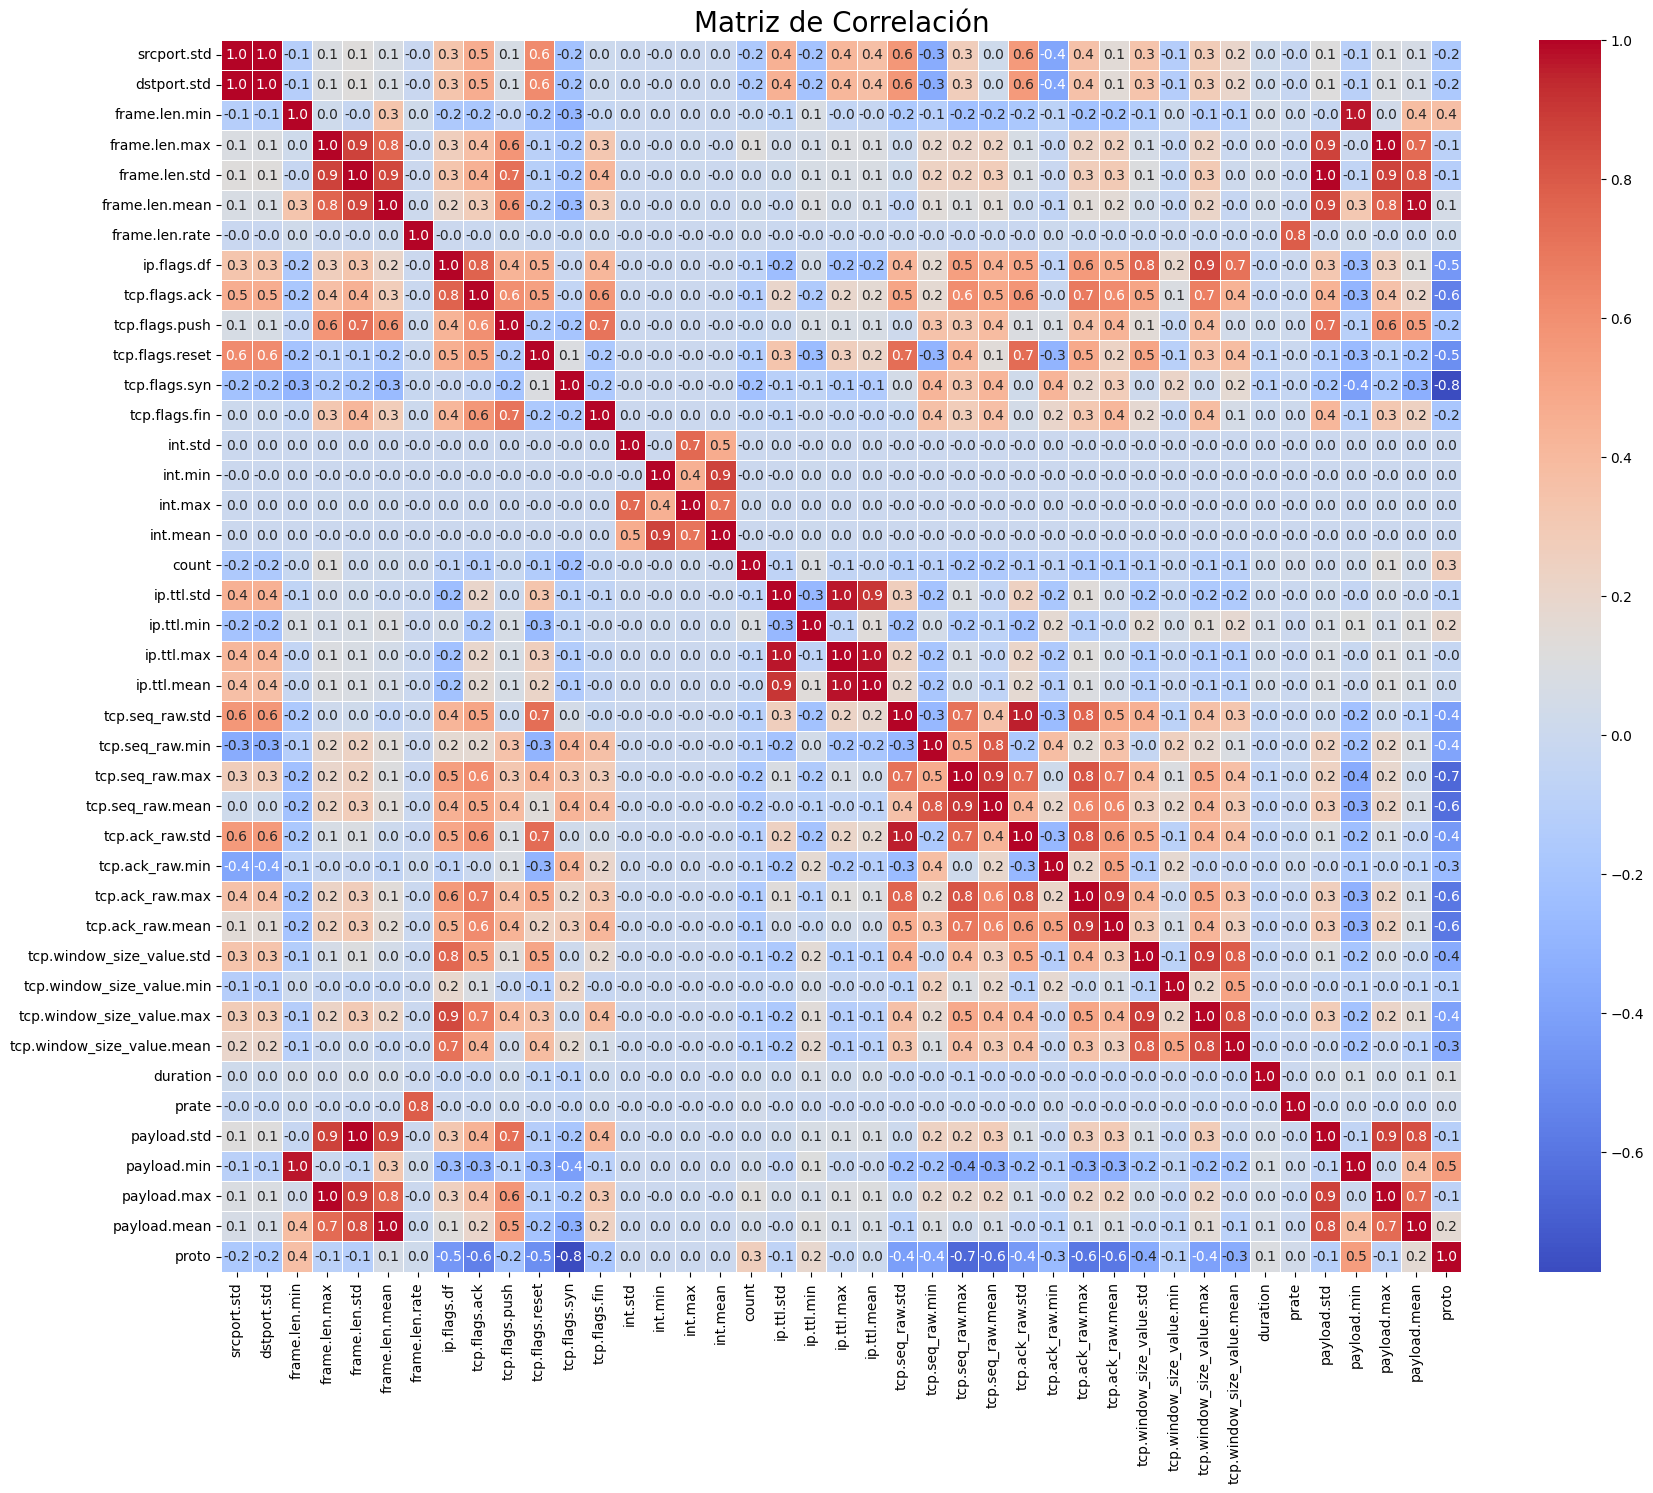

In [12]:
import numpy as np
corr_matrix = X_train.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".1f")
plt.title("Matriz de Correlación", fontsize=20)
plt.show()


## Method 1 : Brute Force

In [13]:
def correlation(dataset, threshold):
    
    # create a set where I will store the names of correlated columns. Sets cannot contain duplicated elements
    col_corr = set()
    
    # create the correlation matrix
    corr_matrix = dataset.corr()
    
    # for each feature in the dataset (columns of the correlation matrix)
    for i in range(len(corr_matrix.columns)):
        
        # check with other features (Not with itself)
        for j in range(i):
            
            # if the correlation is higher than a certain threshold
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                
                # print correlation, and variables examined
                # keep in mind that the columns and rows of the dataframe are identical
                # so we can identify the features being examned by looking for i,j
                # in the column names
                print(abs(corr_matrix.iloc[i, j]), corr_matrix.columns[i], corr_matrix.columns[j])
                
                # get the name of the correlated feature
                colname = corr_matrix.columns[j]
                
                # and add it to our correlated set
                col_corr.add(colname)
                
    return col_corr

In [14]:
corr_features = correlation(X_train, 0.90)
len(set(corr_features))

1.0 dstport.std srcport.std
0.9720460527354214 ip.ttl.max ip.ttl.std
0.9094681371010614 ip.ttl.mean ip.ttl.std
0.9764186145265968 ip.ttl.mean ip.ttl.max
0.9028231538344306 tcp.seq_raw.mean tcp.seq_raw.max
0.9532631167078506 tcp.ack_raw.std tcp.seq_raw.std
0.9124857948600464 tcp.ack_raw.mean tcp.ack_raw.max
0.9996532465954793 payload.std frame.len.std
0.9717974434019288 payload.min frame.len.min
0.9998232656437477 payload.max frame.len.max
0.992985277931503 payload.mean frame.len.mean


10

## We'll Drop the redundant features 

In [15]:
corr_features = ['srcport.std', 'ip.ttl.std','ip.ttl.mean', 'frame.len.mean', 'frame.len.max', 'frame.len.min', 'frame.len.std', 'tcp.ack_raw.std']

In [16]:
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_val.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape, X_val.shape

((1117830, 33), (319400, 33), (159690, 33))

In [18]:
train = pd.concat([X_train, y_train], axis=1).to_csv('train_B.csv', index=False)
val = pd.concat([X_val, y_val], axis=1).to_csv('val_B.csv', index=False)
test = pd.concat([X_test, y_test], axis=1).to_csv('test_B.csv', index=False)

In [21]:
train = pd.read_csv("train_B.csv")
test = pd.read_csv("test_B.csv")

In [22]:
# Separar características y etiquetas para conjunto de entrenamiento
X_train = train.drop(columns=['category'])
y_train = train['category']

# Separar características y etiquetas para conjunto de entrenamiento
X_test = test.drop(columns=['category'])
y_test = test['category']

In [24]:
RF = RandomForestClassifier()

param_grid = {'max_depth': [15]} 
grid = GridSearchCV(RF, param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose=1)
grid.fit(X_train, y_train)

print('Best Cross Validation Score:', grid.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Cross Validation Score: 0.8320111287047224


In [25]:
RF =  grid.best_estimator_

print('Train Score:', RF.score(X_train, y_train))

y_pred = RF.predict(X_test)

start2=time.time()
print('Precision en test: ', accuracy_score(y_test, y_pred))
stop2=time.time()

tiempo2 = stop2 - start2
print(f"Tiempo de prediccion (Test) RF: {tiempo2}s")

Train Score: 0.8637189912598516
Precision en test:  0.8570037570444584
Tiempo de prediccion (Test) RF: 0.27753162384033203s


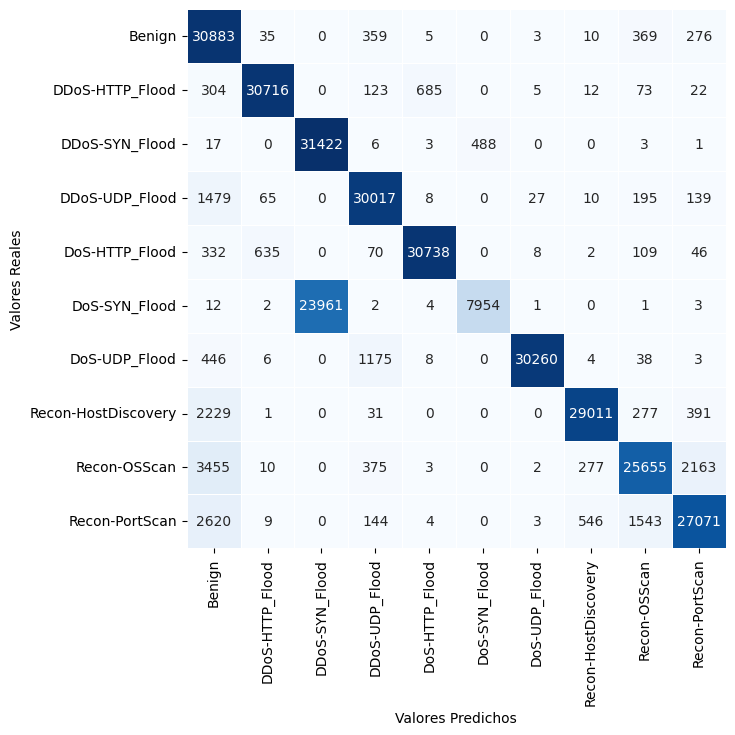

In [26]:
cm = metrics.confusion_matrix(y_test, y_pred)
normalized_matrix = cm #/ cm.sum(axis=1, keepdims=True)

class_names = ['Benign', 'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DDoS-UDP_Flood', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-UDP_Flood', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan']

sns.heatmap(normalized_matrix, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names,
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(7, 7)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

In [27]:
import joblib
joblib.dump(RF, 'RF_model1.pkl')

['RF_model1.pkl']